In [1]:
using DifferentialEquations, Plots, Test, LinearAlgebra, SparseArrays, DiffEqOperators
using Perla1

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\Perla1\nyjg2.ji for Perla1 [c0b4307c-ed70-5091-a49a-e521e9681a02]
└ @ Base loading.jl:1184
┌ Warning: Package Perla1 does not have DiffEqOperators in its dependencies:
│ - If you have Perla1 checked out for development and have
│   added DiffEqOperators as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Perla1
└ Loading DiffEqOperators into Perla1 from project dependency, future warnings for Perla1 are suppressed.


# Using transition matrix based dynamics

In [2]:
# get Q in matrix form for sanity check
function get_Q_matrix(N, μ, θ, θ_d, f0)
    dl = fill(μ, N)
    d = collect(-μ.-(N:-1:0).*(θ/N))
    du = collect((N:-1:1).*(θ/N))
    Q_basis = LinearAlgebra.Tridiagonal(dl,d,du)

    function Q(a)
        Q_basis[1,1] = -(θ + θ_d*(1-f0(a)))
        Q_basis[1,2] = θ + θ_d*(1-f0(a))
        return Q_basis
    end 

    return Q
end

# solve model with matrix Q
function solve_transition_dynamics_matrix(Q_matrix, f_0, T)
    # solve transition dynamics given 
    # Q; N by N matrix generator
    # f_0; N vector of initial distribution
    # T; Float64 terminal time
    df(f,p,a) = Q_matrix(a)' * f
    prob = DifferentialEquations.ODEProblem(df,f_0,(0.0,T))
    return solve(prob);
end

solve_transition_dynamics_matrix (generic function with 1 method)

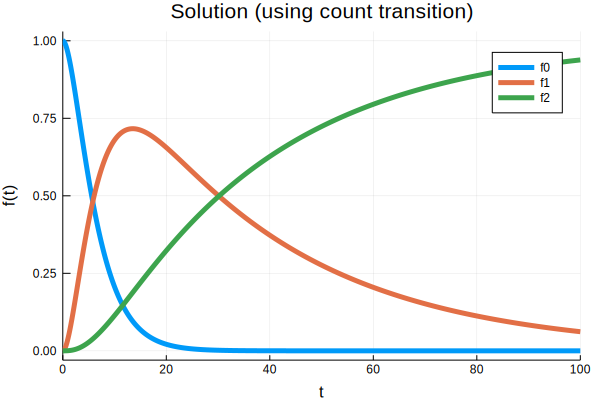

In [3]:
# simple duopoly
N = 2
T = 100.0
μ = 0.0
θ = 0.06 # baseline parameter from Perla16 (Appendix E.4)
θ_d = 0.21 # baseline parameter from Perla16 (Appendix E.4)
f0(a) = (θ_d + θ) / (θ_d + θ * exp(θ_d + θ)*a)

# define generator
Q = get_Q_matrix(N, μ, θ, θ_d, f0)

# solve the corresponding ODE
f_0 = [1.0; 0.0; 0.0]
sol_count = solve_transition_dynamics_matrix(Q, f_0, T)

# convert to the counting solution
f0_count(a) = sol_count(a)[1]
f1_count(a) = sol_count(a)[2]
f2_count(a) = sol_count(a)[3]

# plot
plot(sol_count,linewidth=5,
    title="Solution (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

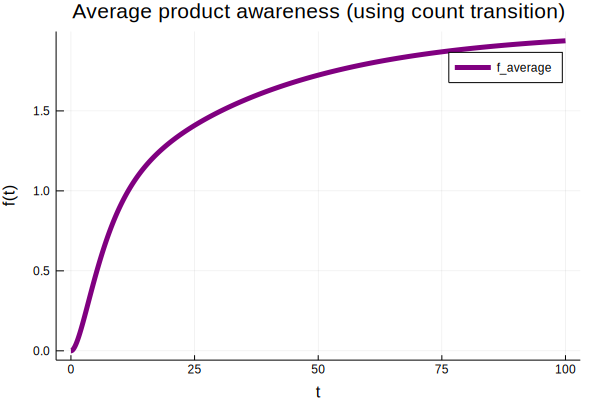

In [4]:
f_count(a) = dot(0:N, sol_count(a)) # average product awareness
plot(0:0.01:T, f_count,linewidth=5,
    title="Average product awareness (using count transition)",
    xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple")

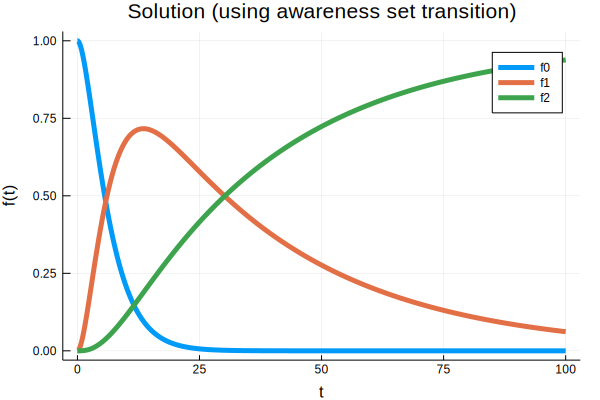

In [5]:
# simple duopoly, using awareness set
# define generator
f_hat0(a) = (θ_d + θ) / (θ_d + θ*exp((θ_d + θ)*a)) # (A.4) in appendix
f_hat_0 = [1.0; 0.0; 0.0; 0.0]
Q_hat(a) = [-(θ + θ_d*(1-f0(a))) (θ + θ_d*(1-f0(a)))/N (θ + θ_d*(1-f0(a)))/N 0.0; 
            0.0 -θ/2 0.0 θ/2;
            0.0 0.0 -θ/2 θ/2;
            0.0 0.0 0.0 0.0]

# solve the corresponding ODE
sol_awareness = solve_transition_dynamics_matrix(Q_hat, f_hat_0, T)

# convert to the counting solution
f0_awareness(a) = sol_awareness(a)[1] # no product
f1_awareness(a) = sol_awareness(a)[2] + sol_awareness(a)[3] # product 1 or product 2
f2_awareness(a) = sol_awareness(a)[4] # two products

# plot
plot(0:0.01:T, [f0_awareness, f1_awareness, f2_awareness],linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

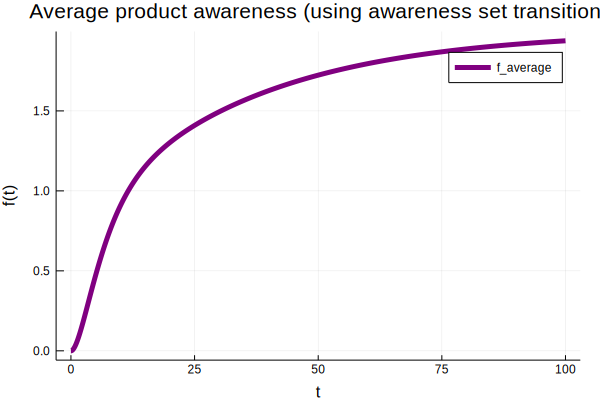

In [6]:
f_awareness(a) = dot(0:N, [f0_awareness(a); f1_awareness(a); f2_awareness(a)]) # average product awareness
plot(0:0.01:T, f_count,linewidth=5,
    title="Average product awareness (using awareness set transition)",
    xaxis="t",yaxis="f(t)",label=["f_average"],linecolor="purple")

In [7]:
@test f0_count.(0:0.1:T) ≈ f0_awareness.(0:0.1:T) atol=1e-4
@test f1_count.(0:0.1:T) ≈ f1_awareness.(0:0.1:T) atol=1e-4
@test f2_count.(0:0.1:T) ≈ f2_awareness.(0:0.1:T) atol=1e-4
@test f_count.(0:0.1:T) ≈ f_awareness.(0:0.1:T) atol=1e-4

Test Passed

# Using matrix-free methods

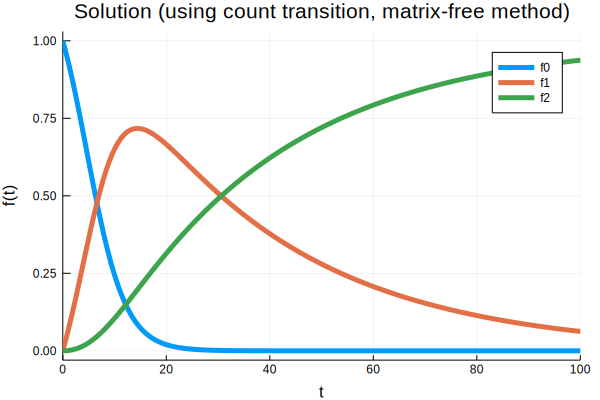

In [8]:
function get_Q_base(N, μ, θ)
    # construct (N+1) by (N+1) base matrix such that
    # the last N rows of base_matrix correspond to the last N rows of Q(a) 
    # based on (A.3) in appendix
    dl = fill(μ, N)
    d = collect(-μ.-(N:-1:0).*(θ/N))
    du = collect((N:-1:1).*(θ/N))
    return SparseArrays.spdiagm(-1 => dl, 0 => d, 1 => du)
end

function solve_transition_dynamics_matrix_free(N, μ, θ, θ_d, f0, f_0, T)
    Q_base = get_Q_base(N, μ, θ)
    
    function update_Q(Q, u, p, a) 
        Q[1,1] = -(θ + θ_d*(1-f0(a)))
        Q[2,1] = θ + θ_d*(1-f0(a))
    end
    
    # transition dynamics (linear in f)
    f1 = DiffEqArrayOperator(Q_base'; update_func = update_Q)
    # there's no nonlinear term
    f2 = DiffEqArrayOperator(zeros(Float64, N+1, N+1)) 
    # define a split ODE problem, only with linear term
    prob = SplitODEProblem(f1, f2, f_0, (0.0, T))
    # solve it
    sol = solve(prob)
end

f0_a(a) = (θ_d + θ) / (θ_d + θ*exp((θ_d + θ)*a)) 
sol_count = solve_transition_dynamics_matrix_free(N, μ, θ, θ_d, f0_a, f_0, T)

# convert to the counting solution
f0_count_matrix_free(a) = sol_count(a)[1]
f1_count_matrix_free(a) = sol_count(a)[2]
f2_count_matrix_free(a) = sol_count(a)[3]
f_count_matrix_free(a) = dot(0:N, sol_count(a)) # average product awareness

# plot
plot(sol_count,linewidth=5,
    title="Solution (using count transition, matrix-free method)",
    xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

In [9]:
# check if they yield identical results
@test f0_count.(0:0.1:T) ≈ f0_count_matrix_free.(0:0.1:T) atol=1e-4
@test f1_count.(0:0.1:T) ≈ f1_count_matrix_free.(0:0.1:T) atol=1e-4
@test f2_count.(0:0.1:T) ≈ f2_count_matrix_free.(0:0.1:T) atol=1e-4
@test f_count.(0:0.1:T) ≈ f_count_matrix_free.(0:0.1:T) atol=1e-4

Test Passed

# Using Perla1 package 

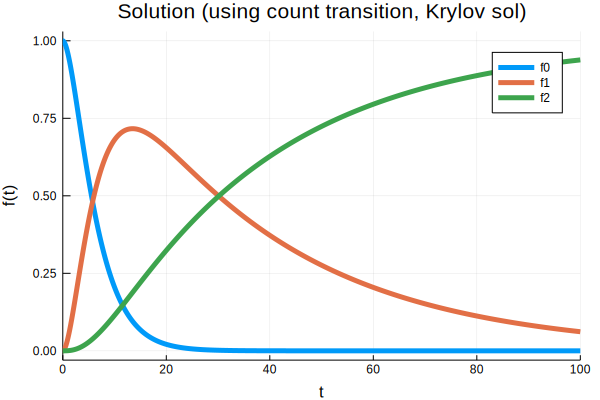

In [10]:
using ExponentialUtilities, Parameters

# define dynamics
function Q!(df, f, p, t)
    @unpack μ, θ, θ_d, f0, cohorts = p
    N = cohorts[1]
    df[1] = -(θ + θ_d*(1-f0(t)))*f[1] + μ*f[2]
    for i in 2:N
        df[i] = θ*((N+2-i)/N)*f[i-1] - (μ+θ*((N+1-i)/N))*f[i] + μ*f[i+1]
    end
    df[2] = (θ + θ_d*(1-f0(t)))*f[1] - (μ+θ*((N-1)/N))*f[2] + μ*f[3]
    df[end] = (θ/N)*f[N] - μ*f[N+1]
end


# solve krylov
params = (μ = μ, θ = θ, θ_d = θ_d, f0 = f0, cohorts = (N, ))
sol_count_krylov = solve_transition_dynamics(Q!, params, f_0, T; dt = 0.1)

f0_count_krylov(a) = sol_count_krylov(a)[1]
f1_count_krylov(a) = sol_count_krylov(a)[2]
f2_count_krylov(a) = sol_count_krylov(a)[3]
f_count_krylov(a) = dot(0:N, sol_count_krylov(a)) # average product awareness

# plot
plot(sol_count_krylov,linewidth=5,
    title="Solution (using count transition, Krylov sol)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

In [11]:
# without package
function generate_operator() 
    Q_base = get_Q_base(N, μ, θ)'
    function awareness_operator_basis(du,u,p,t)
        Q_base[1,1] = -(θ + θ_d*(1-f0(t)))
        Q_base[2,1] = θ + θ_d*(1-f0(t))
        mul!(du, Q_base, u)
    end
    operator = MatrixFreeOperator(awareness_operator_basis, (1,1)) # extra argument p=(1,1) is dummy
    return operator
end

# solve krylov
operator = generate_operator() 
prob = ODEProblem(operator,f_0,(0.0,T))
sol_count_krylov_without_package = solve(prob, HochOst4(krylov=true, m=2), dt=0.01)

f0_count_krylov_without_package(a) = sol_count_krylov_without_package(a)[1]
f1_count_krylov_without_package(a) = sol_count_krylov_without_package(a)[2]
f2_count_krylov_without_package(a) = sol_count_krylov_without_package(a)[3]
f_count_krylov_without_package(a) = dot(0:N, sol_count_krylov_without_package(a)) # average product awareness

# plot
plot(sol_count_krylov_without_package,linewidth=5,
    title="Solution (using count transition, Krylov sol, without relying on package)",
     xaxis="t",yaxis="f(t)",label=["f0" "f1" "f2"])

In [12]:
# check if they yield package-based solutions yield identical results with the ones without relying on solutions
@test f0_count_krylov.(0:0.1:T) ≈ f0_count_krylov_without_package.(0:0.1:T) atol=1e-1
@test f1_count_krylov.(0:0.1:T) ≈ f1_count_krylov_without_package.(0:0.1:T) atol=1e-1
@test f2_count_krylov.(0:0.1:T) ≈ f2_count_krylov_without_package.(0:0.1:T) atol=1e-1
@test f_count_krylov.(0:0.1:T) ≈ f_count_krylov_without_package.(0:0.1:T) atol=1e-1

Test Passed

In [13]:
# check if they yield CLOSE results with actual solutions
@test f0_count.(0:0.1:T) ≈ f0_count_krylov.(0:0.1:T) atol=1e+1
@test f1_count.(0:0.1:T) ≈ f1_count_krylov.(0:0.1:T) atol=1e+1
@test f2_count.(0:0.1:T) ≈ f2_count_krylov.(0:0.1:T) atol=1e+1
@test f_count.(0:0.1:T) ≈ f_count_krylov.(0:0.1:T) atol=1e+1

Test Passed